## Набор данных Forest Cover Type

Для начала импортируем основные библиотеки

In [1]:
import pandas as pd
import numpy as np
import pickle

Считаем наш набор данных и приведем его к презентабельному виду в соответствии с описанием

In [2]:
num_cols = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
]

cat_cols = []

cnt = 1
for i in range(10, 14):
    cat_cols.append( f'Wilderness_Area{cnt}')
    cnt+=1

cnt = 1
for i in range(14, 54):
    cat_cols.append(f'Soil_Type{cnt}')
    cnt+=1

feature_cols = num_cols + cat_cols

target_col = 'Cover_Type'

cols = feature_cols + [target_col]

covtype_data = pd.read_csv("covtype.data", 
                  sep=',', 
                  names=cols)

print("Размерность датасета:", covtype_data.shape)
covtype_data.head()

Размерность датасета: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Заранее разделим наши данные на тестовую, валидационную и тренировочную выборки, чтобы не допустить утечек. 

В информационном файле сказано следующее:

		-- first 11,340 records used for training data subset
		-- next 3,780 records used for validation data subset
		-- last 565,892 records used for testing data subset

In [3]:
X_train = covtype_data[feature_cols][0:11340]
y_train = covtype_data[target_col][0:11340]

# дополнительно выделим тренировочную подвыборку размером 100 для GridSearchCV
train_sample_size = 100
train_data = covtype_data[0:11340].sample(n = train_sample_size)
X_train_sample = train_data[feature_cols].copy()
y_train_sample = train_data[target_col].copy()

X_valid = covtype_data[feature_cols][11340:15120]
y_valid = covtype_data[target_col][11340:15120]

X_test = covtype_data[feature_cols][15120:581012]
y_test = covtype_data[target_col][15120:581012]

# дополнительно выделим тестовую подвыборку размером 10000 для модели KNN
test_sample_size = 10000
knn_test_data = covtype_data[15120:581012].sample(n = test_sample_size)
X_test_sample = knn_test_data[feature_cols].copy()
y_test_sample = knn_test_data[target_col].copy()

print(X_train.shape, X_train_sample.shape, y_train.shape, y_train_sample.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, X_test_sample.shape, y_test.shape, y_test_sample.shape)

(11340, 54) (100, 54) (11340,) (100,)
(3780, 54) (3780,)
(565892, 54) (10000, 54) (565892,) (10000,)


Воспользуемся результатами, полученными на этапе анализа и приведем данные к виду, пригодному для обучения моделей

In [4]:
def make_soil_type_num(data):  
    # создадим список колонок Soil_Type
    soil_columns = [c for c in data.columns if "Soil" in c]

    soil_type = [None] * data['Soil_Type1'].size
    # просуммируем их
    for c in soil_columns:
        i = 0
        for index in data[c]:
            if (index == 1):
                soil_type[i] = int(c[9:])
            i+=1

    data.drop(columns=soil_columns, inplace=True)
    data['Soil_Type'] = soil_type

def transform(data):
    # добавим числовой столбец типа почвы вместо one-hot-encoded
    make_soil_type_num(data)
    
    # добавим линейные комбинации столбцов расстояний
    data['Euclidian_Distance_To_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2 + data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['Mean_Elevation_Vertical_Distance_Hydrology'] = (data['Elevation'] + data['Vertical_Distance_To_Hydrology'])/2
    data['Mean_Distance_Hydrology_Firepoints'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Fire_Points'])/2
    data['Mean_Distance_Hydrology_Roadways'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways'])/2
    data['Mean_Distance_Firepoints_Roadways'] = (data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Roadways'])/2

    # добавим произведения категориальных признаков
    data['WA1_To_ST'] = (data['Wilderness_Area1'] * data['Soil_Type'])
    data['WA2_To_ST'] = (data['Wilderness_Area2'] * data['Soil_Type'])
    data['WA3_To_ST'] = (data['Wilderness_Area3'] * data['Soil_Type'])
    data['WA4_To_ST'] = (data['Wilderness_Area4'] * data['Soil_Type'])

    # заменим столбцы для которых корень показал лучшее значение
    data['sqrt' + 'Horizontal_Distance_To_Hydrology'] = np.sqrt(data['Horizontal_Distance_To_Hydrology'])
    data['sqrt' + 'Mean_Distance_Hydrology_Roadways'] = np.sqrt(data['Mean_Distance_Hydrology_Roadways'])
    data['sqrt' + 'Euclidian_Distance_To_Hydrology'] = np.sqrt(data['Euclidian_Distance_To_Hydrology'])

    # окончательный список признаков
    wilderness_areas = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
    transformed_features = ['WA1_To_ST', 'WA2_To_ST', 'WA3_To_ST', 'WA4_To_ST', 'sqrtHorizontal_Distance_To_Hydrology', 'sqrtMean_Distance_Hydrology_Roadways', 'sqrtEuclidian_Distance_To_Hydrology', 
                            'Mean_Elevation_Vertical_Distance_Hydrology', 'Mean_Distance_Firepoints_Roadways', 'Mean_Distance_Hydrology_Firepoints']

    all_features = (['Elevation', 'Aspect', 'Slope', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points' ] + wilderness_areas +
                    ['Soil_Type'] + transformed_features)
    data = data[all_features]

In [5]:
transform(X_train)
transform(X_train_sample)
transform(X_valid)
transform(X_test)
transform(X_test_sample)

In [6]:
print(X_train.shape, y_train.shape)

(11340, 27) (11340,)


Также нам понадобится отдельная обработка признаков для модели `Naive Bayes`, так как нам не подойдут средние значения и категориальные признаки

In [7]:
def drop_soil_type(data):  
    # создадим список колонок Soil_Type
    soil_columns = [c for c in data.columns if "Soil" in c]

    soil_type = [None] * data['Soil_Type1'].size
    # просуммируем их
    for c in soil_columns:
        i = 0
        for index in data[c]:
            if (index == 1):
                soil_type[i] = int(c[9:])
            i+=1

    data.drop(columns=soil_columns, inplace=True)

def drop_wa_type(data):  
    # создадим список колонок Wilderness_Area
    wa_columns = [c for c in data.columns if "Wilderness" in c]

    wa_type = [None] * data['Wilderness_Area1'].size
    # просуммируем их
    for c in wa_columns:
        i = 0
        for index in data[c]:
            if (index == 1):
                wa_type[i] = int(c[15:])
            i+=1

    data.drop(columns=wa_columns, inplace=True)

def transform_for_bayes(data):
    drop_soil_type(data)
    drop_wa_type(data)

In [25]:
# перед применением необходимо заново запустить ячейки 
# со считыванием данных и разделением на train/validation/test
transform_for_bayes(X_train)
transform_for_bayes(X_train_sample)
transform_for_bayes(X_valid)
transform_for_bayes(X_test)
transform_for_bayes(X_test_sample)

In [26]:
print(X_train.shape, y_train.shape)

(11340, 10) (11340,)


Теперь наши данные готовы быть переданы на обучение

## Реализация алгоритмов машинного обучения

На этапе обучения мы сравним мои реализации с моделями из `scikit-learn`. 

Ниже приведены реализации следующих алгоритмов:
- Linear/Logistic Regression
- SVM
- KNN 
- Naive Bayes

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

### `Логистическая регрессия (англ. logistic regression)`

Метод построения линейного классификатора, позволяющий оценивать апостериорные вероятности принадлежности объектов классам

In [9]:
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

class MyMulticlassLogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, max_iter=1000, lr=0.1, mu=0.0001):
        self.max_iter = max_iter
        self.lr = lr
        self.mu = mu
    
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        
        self._label_encoder = OneHotEncoder(sparse=False)
        self.y_ = self._label_encoder.fit_transform(y.reshape(-1, 1))

        self.w_ = np.zeros((X.shape[1], self.y_.shape[1]))

        # Gradient descent
        step = 0
        while step < self.max_iter:
            step += 1
            self.w_ -= self.lr * self._gradient()

            # Loss calculation
            Z = - X @ self.w_
            N = X.shape[0]
            self.loss = 1 / N * (np.trace(X @ self.w_ @ self.y_.T) + np.sum(np.log(np.sum(np.exp(Z), axis = 1))))

        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        Z = -X @ self.w_
        P = softmax(Z, axis=1)
        return np.argmax(P, axis = 1) + 1

    def _gradient(self):
        Z = - self.X_ @ self.w_
        P = softmax(Z, axis=1)
        N = self.X_.shape[0]
        grad = 1 / N * (self.X_.T @ (self.y_ - P)) + 2 * self.mu * self.w_
        return grad

### `Метод опорных векторов (англ. SVM — support vector machine)`

Основная идея метода заключается в построении гиперплоскости, разделяющей объекты выборки оптимальным способом. Алгоритм работает в предположении, что чем больше расстояние (зазор) между разделяющей гиперплоскостью и объектами разделяемых классов, тем меньше будет средняя ошибка классификатора

In [10]:
from sklearn.preprocessing import LabelEncoder

class MySVM(ClassifierMixin, BaseEstimator):
    def __init__(self, C=1, max_iter=50):
        self.C = C
        self.max_iter = max_iter

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        
        n_samples, n_features = X.shape

        # Normalize labels
        self._label_encoder = LabelEncoder()
        self.y_ = self._label_encoder.fit_transform(y)

        # Initialize primal and dual coefficients
        n_classes = len(self._label_encoder.classes_)
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # Pre-compute norms
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        ind = np.arange(n_samples)
        for it in range(self.max_iter):
            for j in range(n_samples):
                i = ind[j]

                # All-zero samples can be safely ignored
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(i)

                # Solve subproblem for the ith sample
                delta = self.__solve_subproblem(g, norms, i)

                # Update primal and dual coefficients
                self.coef_ += (delta * X[i][:, np.newaxis]).T
                self.dual_coef_[:, i] += delta

        # Return the classifier
        return self

    def predict(self, X):
        
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        decision = np.dot(X, self.coef_.T)
        pred = decision.argmax(axis=1)
        return self._label_encoder.inverse_transform(pred)

    def _partial_gradient(self, i):
        # Partial gradient for the ith sample
        g = np.dot(self.X_[i], self.coef_.T) + 1
        g[self.y_[i]] -= 1
        return g

    def _projection_simplex(self, v, z=1):
        # Projection onto the simplex:
        #     w^* = argmin_w 0.5 ||w-v||^2 s.t. \sum_i w_i = z, w_i >= 0
        n_features = v.shape[0]
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u) - z
        ind = np.arange(n_features) + 1
        cond = u - cssv / ind > 0
        rho = ind[cond][-1]
        theta = cssv[cond][-1] / float(rho)
        w = np.maximum(v - theta, 0)
        return w

    def __solve_subproblem(self, g, norms, i):
        # Prepare inputs to the projection.
        Ci = np.zeros(g.shape[0])
        Ci[self.y_[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # Compute projection onto the simplex.
        beta = self._projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

### `Метод k ближайших соседей (англ. KNN — k Nearest Neighbours)`

Для повышения надёжности классификации объект относится к тому классу, которому принадлежит большинство из его соседей, то есть $k$ ближайших к нему объектов обучающей выборки

In [11]:
class MyKNN(ClassifierMixin, BaseEstimator):
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self
    
    def predict(self, X):
        
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        pred = np.ndarray((X.shape[0],))
        for i, x in enumerate(X):
            neighbors = np.argpartition(((self.X_ - X[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.y_[neighbors], return_counts=True)
            pred[i] = values[counts.argmax()]
        return pred

### `Наивный байесовский классификатор (англ. naive Bayes)`

Простой вероятностный классификатор, основанный на применении теоремы Байеса со строгими (наивными) предположениями о независимости

In [12]:
# Bayes Theorem form
# P(y|X) = P(X|y) * P(y) / P(X)
class MyNaiveBayes(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Store the classes seen during fit
        self.classes_ = np.unique(y)

        self.X_ = X
        self.y_ = y
        
        self.count_ = len(self.classes_)
        self.rows_ = X.shape[0]
        
        self.mean_, self.var_ = self._calc_statistics()
        self.prior_ = self._calc_prior()

        # Return the classifier
        return self
        
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        pred = [self._calc_posterior(f) for f in X]
        return pred

    def _calc_prior(self):
        # Prior probability P(y)
        # Calculate prior probabilities
        prior = (pd.DataFrame(self.X_).groupby(self.y_).apply(lambda x: len(x)) / self.rows_).to_numpy()

        return prior
    
    def _calc_statistics(self):
        # Calculate mean, variance for each column and convert to numpy array
        mean = pd.DataFrame(self.X_).groupby(self.y_).apply(pd.DataFrame.mean).to_numpy()
        var = pd.DataFrame(self.X_).groupby(self.y_).apply(pd.DataFrame.var).to_numpy()
              
        return mean, var
    
    def _gaussian_density(self, class_idx, x):     
        # Calculate probability from gaussian density function (normally distributed)
        # we will assume that probability of specific target value given specific class is normally distributed 
        
        # Probability density function derived from wikipedia:
        # (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        mean = self.mean_[class_idx]
        var = self.var_[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob

    def _calc_posterior(self, x):
        posteriors = []

        # Calculate posterior probability for each class
        for i in range(self.count_):
            prior = np.log(self.prior_[i]) # use the log to make it more numerically stable
            conditional = np.sum(np.log(self._gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # Return class with highest posterior probability
        return self.classes_[np.argmax(posteriors)]

## Обучение 

Теперь нам необходимо провети настройку гиперпараметров для моделей, у которых таковые имеются. Для этого импортируем все необходимое

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Затем нам нужно обучить модели с лучшими параметрами и прозвести оценку метрик:
- Confusion Matrix ✔
- Accuracy ✔
- Recall ✔
- Precision ✔
- ROC_AUC curve ✘ (т.к. применяется лишь для бинарной классификации)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def find_metrics(classifier, X, y):
    y_pred = classifier.predict(X)
    forest_cover_type_classes  = [  'Spruce/Fir (1)',
                                    'Lodgepole Pine (2)',
                                    'Ponderosa Pine (3)',
                                    'Cottonwood/Willow (4)',
                                    'Aspen (5)',
                                    'Douglas-fir (6)',
                                    'Krummholz (7)' 
                                 ]
    print(classification_report(y, y_pred, target_names=forest_cover_type_classes))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6, 7]).plot()
    plt.show()

Теперь перейдем непосредственно к обучению и сравнению реализаций

### Logistic Regression

#### `1. MyMulticlassLogisticRegression`

In [20]:
myLR_pipeline = make_pipeline(StandardScaler(), MyMulticlassLogisticRegression())

param_grid = {
    'mymulticlasslogisticregression__max_iter': [100, 1000, 10000, 100000],
    'mymulticlasslogisticregression__lr': [0.1, 0.05, 0.01, 0.001],
    'mymulticlasslogisticregression__mu': [0.01, 0.0001, 0.000001]
}

randomized_search = RandomizedSearchCV(myLR_pipeline, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
randomized_search.fit(X_train_sample, y_train_sample)

print(randomized_search.best_params_)
print(randomized_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'mymulticlasslogisticregression__mu': 1e-06, 'mymulticlasslogisticregression__max_iter': 1000, 'mymulticlasslogisticregression__lr': 0.01}
0.5733528138528139


In [ ]:
myLR_pipeline_best = make_pipeline(StandardScaler(), 
                                   MyMulticlassLogisticRegression(mu=1e-06, max_iter=1000, lr=0.1))
myLR_pipeline_best.fit(X_train, y_train)

In [23]:
with open('dumps/my_logistic_regression.pkl', 'wb') as f:
    pickle.dump(myLR_pipeline_best, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.67      0.54      0.60    209680
   Lodgepole Pine (2)       0.81      0.46      0.59    281141
   Ponderosa Pine (3)       0.60      0.55      0.57     33594
Cottonwood/Willow (4)       0.06      0.92      0.12       587
            Aspen (5)       0.07      0.70      0.12      7333
      Douglas-fir (6)       0.26      0.56      0.35     15207
        Krummholz (7)       0.19      0.90      0.32     18350

             accuracy                           0.52    565892
            macro avg       0.38      0.66      0.38    565892
         weighted avg       0.70      0.52      0.57    565892



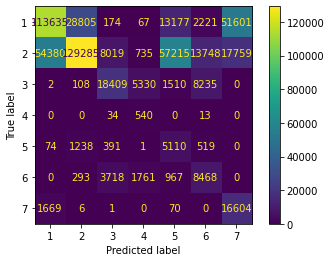

In [24]:
with open('dumps/my_logistic_regression.pkl','rb') as f:
    my_logistic_regression = pickle.load(f)
find_metrics(my_logistic_regression, X_test, y_test)

#### `2. LogisticRegression`

In [28]:
from sklearn.linear_model import LogisticRegression

LR_pipeline = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {
    'logisticregression__C': np.arange(1, 5),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(LR_pipeline, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'logisticregression__C': 4, 'logisticregression__solver': 'newton-cg'}
0.5861111633062949


In [29]:
with open('dumps/logistic_regression.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.67      0.63      0.65    209680
   Lodgepole Pine (2)       0.79      0.51      0.62    281141
   Ponderosa Pine (3)       0.69      0.58      0.63     33594
Cottonwood/Willow (4)       0.09      0.90      0.17       587
            Aspen (5)       0.08      0.77      0.15      7333
      Douglas-fir (6)       0.31      0.66      0.42     15207
        Krummholz (7)       0.33      0.89      0.48     18350

             accuracy                           0.58    565892
            macro avg       0.42      0.71      0.45    565892
         weighted avg       0.70      0.58      0.62    565892



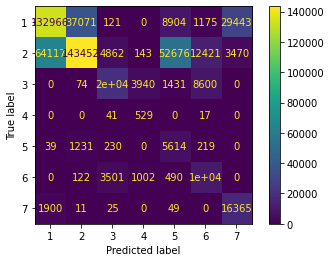

In [18]:
with open('dumps/logistic_regression.pkl','rb') as f:
    logistic_regression = pickle.load(f)
find_metrics(logistic_regression, X_test, y_test)

### SVM

#### `1. MySVM`

In [15]:
mySVM_pipeline = make_pipeline(StandardScaler(), MySVM())

param_grid = {
    'mysvm__C': [1, 3, 5, 10],
    'mysvm__max_iter': [50, 100, 1000]
}

grid_search = GridSearchCV(mySVM_pipeline, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train_sample, y_train_sample)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'mysvm__C': 5, 'mysvm__max_iter': 1000}
0.4996515151515151


In [ ]:
mySVM_pipeline_best = make_pipeline(StandardScaler(), 
                               MySVM(C=5, max_iter=1000))
mySVM_pipeline_best.fit(X_train, y_train)

In [17]:
with open('dumps/my_svm.pkl', 'wb') as f:
    pickle.dump(mySVM_pipeline_best, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.53      0.88      0.66    209680
   Lodgepole Pine (2)       0.80      0.21      0.33    281141
   Ponderosa Pine (3)       0.55      0.79      0.65     33594
Cottonwood/Willow (4)       0.15      0.42      0.22       587
            Aspen (5)       0.06      0.50      0.11      7333
      Douglas-fir (6)       0.29      0.47      0.36     15207
        Krummholz (7)       0.53      0.37      0.43     18350

             accuracy                           0.51    565892
            macro avg       0.41      0.52      0.39    565892
         weighted avg       0.65      0.51      0.47    565892



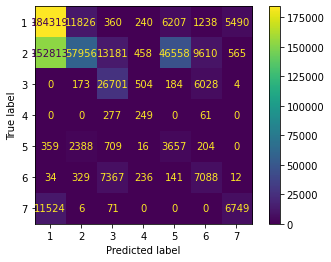

In [18]:
with open('dumps/my_svm.pkl','rb') as f:
    my_svm = pickle.load(f)
find_metrics(my_svm, X_test, y_test)

#### `2. SVC`

In [ ]:
from sklearn.svm import SVC

SVM_pipeline = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=False))
SVM_pipeline.fit(X_train, y_train)

In [12]:
with open('dumps/svm.pkl', 'wb') as f:
    pickle.dump(SVM_pipeline, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.71      0.69      0.70    209680
   Lodgepole Pine (2)       0.82      0.56      0.67    281141
   Ponderosa Pine (3)       0.67      0.65      0.66     33594
Cottonwood/Willow (4)       0.11      0.94      0.19       587
            Aspen (5)       0.11      0.87      0.19      7333
      Douglas-fir (6)       0.35      0.73      0.48     15207
        Krummholz (7)       0.43      0.93      0.59     18350

             accuracy                           0.64    565892
            macro avg       0.46      0.77      0.50    565892
         weighted avg       0.74      0.64      0.67    565892



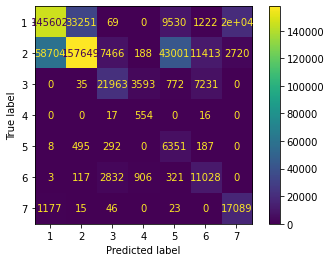

In [13]:
with open('dumps/svm.pkl','rb') as f:
    svm = pickle.load(f)
find_metrics(svm, X_test, y_test)

### KNN 

#### `1. MyKNN`

In [15]:
myKNN_pipeline = make_pipeline(StandardScaler(), MyKNN())

param_grid = {'myknn__k': [1, 3, 5, 10]}

grid_search = GridSearchCV(myKNN_pipeline, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'myknn__k': 10}
0.5124977876048389


In [21]:
with open('dumps/my_knn.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.69      0.65      0.67      3798
   Lodgepole Pine (2)       0.80      0.51      0.62      4866
   Ponderosa Pine (3)       0.61      0.68      0.64       596
Cottonwood/Willow (4)       0.12      1.00      0.22        13
            Aspen (5)       0.11      0.89      0.19       137
      Douglas-fir (6)       0.36      0.73      0.49       278
        Krummholz (7)       0.32      0.95      0.48       312

             accuracy                           0.60     10000
            macro avg       0.43      0.77      0.47     10000
         weighted avg       0.71      0.60      0.63     10000



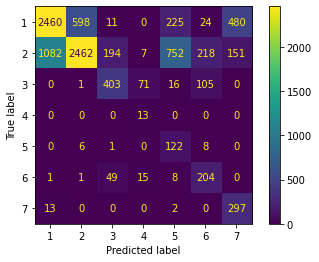

In [19]:
with open('dumps/my_knn.pkl','rb') as f:
    my_knn = pickle.load(f)
find_metrics(my_knn, X_test_sample, y_test_sample)

#### `2. KNeighborsClassifier`

In [20]:
from sklearn.neighbors import KNeighborsClassifier

KNN_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 10]}

grid_search = GridSearchCV(KNN_pipeline, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kneighborsclassifier__n_neighbors': 10}
0.5124977876048389


In [21]:
with open('dumps/knn.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.68      0.64      0.66    209680
   Lodgepole Pine (2)       0.81      0.50      0.62    281141
   Ponderosa Pine (3)       0.64      0.70      0.67     33594
Cottonwood/Willow (4)       0.11      0.96      0.19       587
            Aspen (5)       0.10      0.91      0.18      7333
      Douglas-fir (6)       0.35      0.75      0.48     15207
        Krummholz (7)       0.33      0.95      0.49     18350

             accuracy                           0.59    565892
            macro avg       0.43      0.77      0.47    565892
         weighted avg       0.71      0.59      0.62    565892



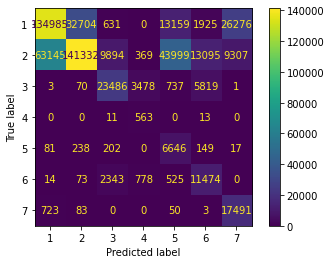

In [22]:
with open('dumps/knn.pkl','rb') as f:
    knn = pickle.load(f)
find_metrics(knn, X_test, y_test)

### Naive Bayes

Важно на этом этапе вернуться к предобработке признаков и провести их трансформацию именно для этого метода

#### `1. MyNaiveBayes`

In [27]:
my_naive_bayes = MyNaiveBayes()
my_naive_bayes.fit(X_train, y_train)

In [28]:
with open('dumps/my_naive_bayes.pkl', 'wb') as f:
    pickle.dump(my_naive_bayes, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.58      0.63      0.60    209680
   Lodgepole Pine (2)       0.80      0.21      0.33    281141
   Ponderosa Pine (3)       0.50      0.18      0.26     33594
Cottonwood/Willow (4)       0.03      0.94      0.06       587
            Aspen (5)       0.05      0.75      0.09      7333
      Douglas-fir (6)       0.16      0.53      0.25     15207
        Krummholz (7)       0.22      0.81      0.35     18350

             accuracy                           0.40    565892
            macro avg       0.33      0.58      0.28    565892
         weighted avg       0.65      0.40      0.42    565892



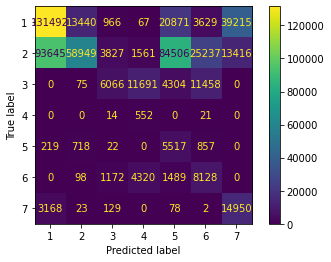

In [29]:
with open('dumps/my_naive_bayes.pkl','rb') as f:
    my_naive_bayes = pickle.load(f)
find_metrics(my_naive_bayes, X_test, y_test)

#### `2. GaussianNB`

In [30]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(GaussianNB(), param_grid, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 0.0002848035868435802}
0.5268472842749047


In [31]:
with open('dumps/naive_bayes.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

                       precision    recall  f1-score   support

       Spruce/Fir (1)       0.61      0.60      0.60    209680
   Lodgepole Pine (2)       0.77      0.33      0.47    281141
   Ponderosa Pine (3)       0.56      0.31      0.40     33594
Cottonwood/Willow (4)       0.04      0.81      0.08       587
            Aspen (5)       0.06      0.74      0.10      7333
      Douglas-fir (6)       0.20      0.52      0.29     15207
        Krummholz (7)       0.23      0.84      0.36     18350

             accuracy                           0.46    565892
            macro avg       0.35      0.59      0.33    565892
         weighted avg       0.65      0.46      0.50    565892



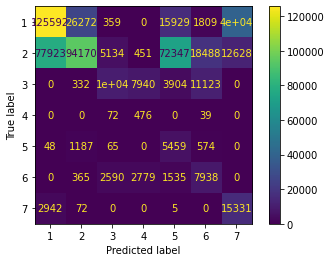

In [32]:
with open('dumps/naive_bayes.pkl','rb') as f:
    naive_bayes = pickle.load(f)
find_metrics(naive_bayes, X_test, y_test)

## Результаты

|                                | Accuracy | Recall | Precision |
| -----------------------------: | :------: | :----: | :-------: |
| MyMulticlassLogisticRegression | 0.52     | 0.52   | 0.70      | 
| LogisticRegression             | 0.58     | 0.58   | 0.70      | 
| MySVM                          | 0.51     | 0.51   | 0.65      | 
| SVC                            | 0.64     | 0.64   | 0.74      | 
| MyKNN                          | 0.60     | 0.60   | 0.71      | 
| KNeighborsClassifier           | 0.59     | 0.59   | 0.71      | 
| MyNaiveBayes                   | 0.40     | 0.40   | 0.65      | 
| GaussianNB                     | 0.46     | 0.46   | 0.65      | 

Лучшей моделью по всем параметрам (кроме времени обучения T_T) оказалась `SVC`, а из моих моделей лучшей оказалась `KNN`. Хотя стоит отметить, что все модели имеют не очень высокие значения метрик, это связано, по большей части, с особеностями самого набора данных. 

Лучше всего модели угадывают:
- `Lodgepole Pine (2)`
- `Spruce/Fir (1)`

а хуже всего:
- `Cottonwood/Willow (4)` 
- `Aspen (5)`
